<a href="https://colab.research.google.com/github/hollyemblem/ufo_embeddings/blob/main/NUFORC_Data_Mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clustering UFO Sightings using OpenAI Text Embeddings

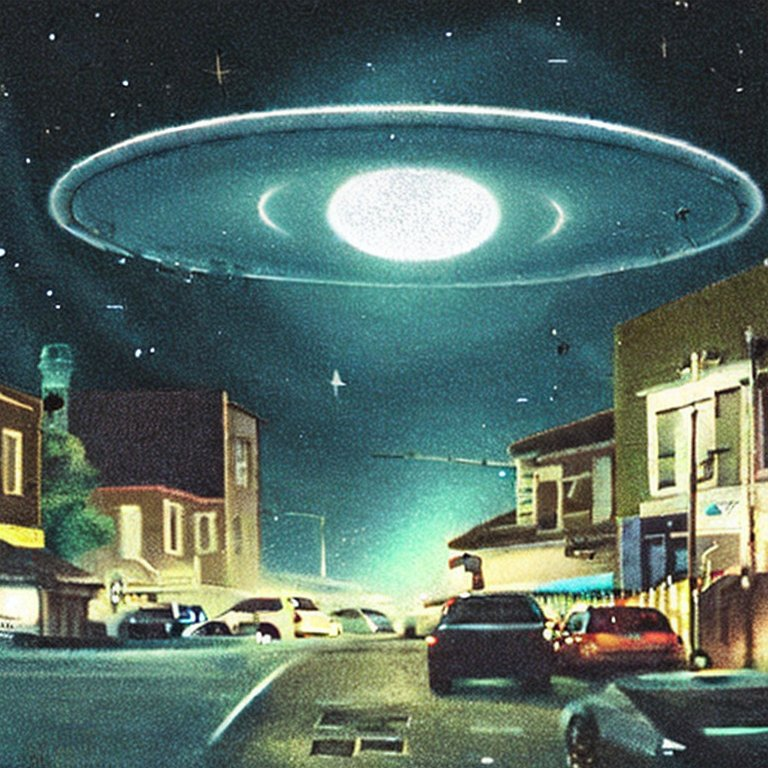

Dataset Source: https://data.world/ck30/ufo-data-nuforc </br>
Prompt: 'photorealistic, grainy image of somewhat busy small town at night, with a massive circle shaped UFO in the sky. hyper-realism. digital art, liminal art.' </br>
Prompt inspiration: https://lexica.art/?q=americana&prompt=6408f06e-db49-4c7f-9681-96e032035b36

### Installing OpenAI & Importing Relevant Libraries

In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.1 MB/s eta 0:00:00


In [ ]:
!pip install folium

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import openai
import os
import folium
from folium.plugins import HeatMap
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans

#### Reading in OpenAPI Key (store yours properly)

In [ ]:
keys_file = open("/content/openai-key.txt")
key_lines = keys_file.readlines()
api_key = key_lines[0].rstrip()
openai.api_key = api_key

#### Reading in UFO Sighting dataset.

##### About NUFORC: </br>
The National UFO Reporting Center was founded in 1974 by noted UFO investigator Robert J. Gribble. The Center’s primary function over the past five decades has been to receive, record, and to the greatest degree possible, corroborate and document reports from individuals who have been witness to unusual, possibly UFO-related events.  Throughout its history, the Center has processed over 170,000 reports, and has distributed its information to thousands of individuals.
*italicized text*


In [ ]:
ufo_data = pd.read_csv('/content/ufo_data_nuforc.csv')

In [ ]:
ufo_data.head()

,posted,date,time,city,state,shape,duration,summary,images,img_link,lat,lng,population
0,03/06/23,03/05/23,20:47:00,Villas,NJ,Diamond,Few minutes long,Low flying aircraft,Yes,https://nuforc.org/webreports/reports/174/S174...,39.0157,-74.9350,9866
1,03/06/23,03/05/23,19:00:00,Mooresville,NC,Orb,10 seconds,Turquoise colored light traveling from south t...,Yes,https://nuforc.org/webreports/reports/174/S174...,35.5847,-80.8266,48431
2,03/06/23,03/05/23,12:30:00,Los Angeles,CA,Changing,4 min,Dark object triangular changed shape,Yes,https://nuforc.org/webreports/reports/174/S174...,34.1141,-118.4068,12121244
3,03/06/23,03/05/23,00:30:00,Brooklyn,NY,Light,Atleast 10 mins,"Light object sky, In Brooklyn towards Manhattan",Yes,https://nuforc.org/webreports/reports/174/S174...,40.6501,-73.9496,2736074
4,03/06/23,03/04/23,23:49:00,Enid,OK,Formation,NaN,It suddenly appeared over rhe neighbors house ...,Yes,https://nuforc.org/webreports/reports/174/S174...,36.4063,-97.8700,51129


In [ ]:
ufo_data.dtypes

posted         object
date           object
time           object
city           object
state          object
shape          object
duration       object
summary        object
images         object
img_link       object
lat           float64
lng           float64
population      int64
dtype: object

#### Cleaning and Visualising Date Ranges of Dataset

In [ ]:
ufo_data['date_value'] = pd.to_datetime(ufo_data['date'])
print(str(ufo_data['date_value'].min()) + ' ' + str(ufo_data['date_value'].max()))

1975-09-01 00:00:00 2023-03-05 00:00:00


In [ ]:
ufo_data[ufo_data['date_value'] == '1975-09-01 00:00:00']

,posted,date,time,city,state,shape,duration,summary,images,img_link,lat,lng,population,date_value
854,09/09/22,09/01/75,21:30:00,Dallas,TX,Disk,5 minutes,"A large disk craft hovered over 635, then inst...",Yes,https://nuforc.org/webreports/reports/170/S170...,32.7935,-96.7667,5668165,1975-09-01


In [ ]:
ufo_data['date_month'] = ufo_data['date_value'].dt.month
ufo_data['date_year'] = ufo_data['date_value'].dt.year
ufo_data['date_month_year'] = ufo_data['date_value'].dt.strftime('%m/%Y')

In [ ]:
date_values = ufo_data.groupby(['date_year']).count().reset_index()
date_count = date_values[['date_year','posted']]
date_count['count_per_month_year'] = date_count['posted']

<ipython-input-13-652ba7f0534b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_count['count_per_month_year'] = date_count['posted']


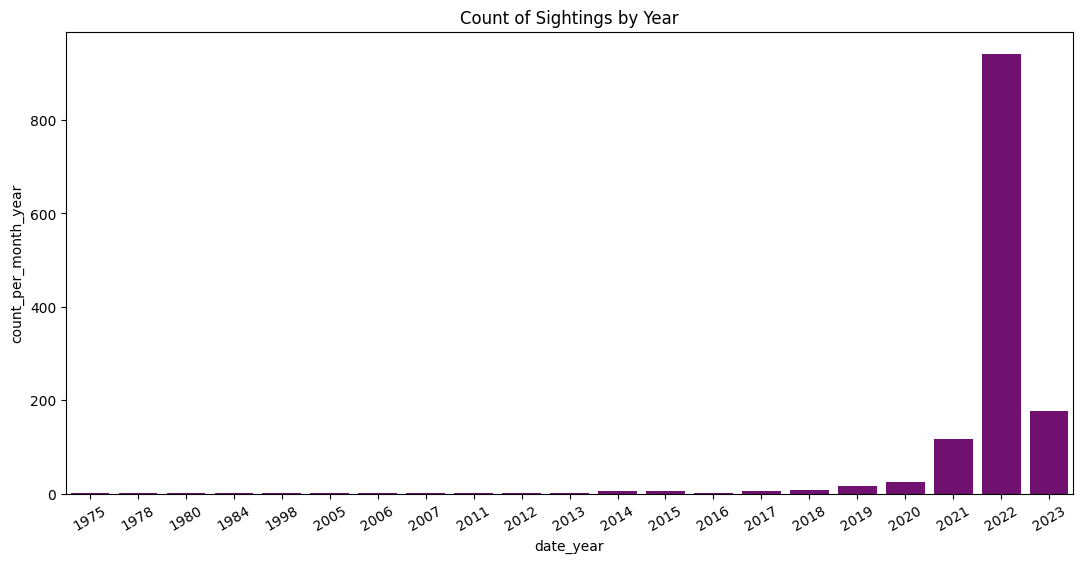

In [ ]:
plt.figure(figsize=(13,6))
ax = sns.barplot(data=date_count, x="date_year", y="count_per_month_year", color='purple')
ax.set_xticklabels(date_count['date_year'], rotation=30)
plt.title('Count of Sightings by Year')
plt.show()

Note: There's an inherent bias in the dataset here, due to ease of availability to report with advent of internet age.

#### Cleaning and Visualising Sightings by State

In [ ]:
state_values = ufo_data.groupby(['state']).count().reset_index()
count_state = state_values[['state','posted']]
count_state.head()

,state,posted
0,AK,7
1,AL,21
2,AR,14
3,AZ,55
4,CA,117


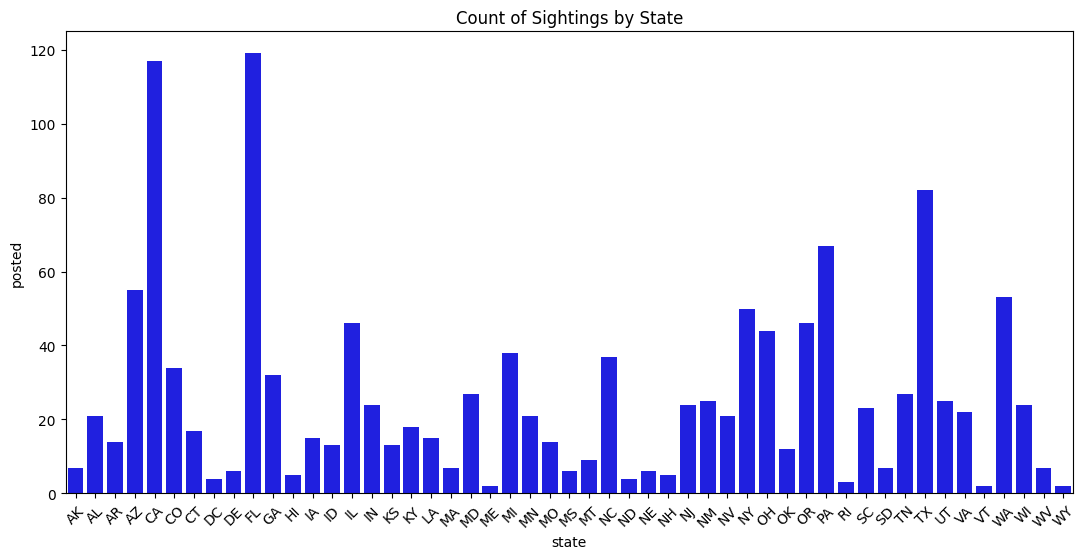

In [ ]:
plt.figure(figsize=(13,6))
ax = sns.barplot(data=count_state, x="state", y="posted", color='blue')
ax.set_xticklabels(count_state['state'], rotation=45)
plt.title('Count of Sightings by State')
plt.show()

Note: Obtaining State population metrics would normalise this.

#### Using Folium to Visualise Geospatial Data

In [ ]:
## Preparing dataset
lat_lng = ufo_data.groupby(['lat', 'lng']).count().reset_index()
lat_lng['count'] = lat_lng['posted']

In [ ]:
ufo_data.head()

,posted,date,time,city,state,shape,duration,summary,images,img_link,lat,lng,population,date_value,date_month,date_year,date_month_year
0,03/06/23,03/05/23,20:47:00,Villas,NJ,Diamond,Few minutes long,Low flying aircraft,Yes,https://nuforc.org/webreports/reports/174/S174...,39.0157,-74.9350,9866,2023-03-05,3,2023,03/2023
1,03/06/23,03/05/23,19:00:00,Mooresville,NC,Orb,10 seconds,Turquoise colored light traveling from south t...,Yes,https://nuforc.org/webreports/reports/174/S174...,35.5847,-80.8266,48431,2023-03-05,3,2023,03/2023
2,03/06/23,03/05/23,12:30:00,Los Angeles,CA,Changing,4 min,Dark object triangular changed shape,Yes,https://nuforc.org/webreports/reports/174/S174...,34.1141,-118.4068,12121244,2023-03-05,3,2023,03/2023
3,03/06/23,03/05/23,00:30:00,Brooklyn,NY,Light,Atleast 10 mins,"Light object sky, In Brooklyn towards Manhattan",Yes,https://nuforc.org/webreports/reports/174/S174...,40.6501,-73.9496,2736074,2023-03-05,3,2023,03/2023
4,03/06/23,03/04/23,23:49:00,Enid,OK,Formation,NaN,It suddenly appeared over rhe neighbors house ...,Yes,https://nuforc.org/webreports/reports/174/S174...,36.4063,-97.8700,51129,2023-03-04,3,2023,03/2023


### Non-Normalised Map and Heatmap

In [ ]:

# Create a map centered at a specific location (e.g., coordinates of a city)
map_center = [40.7128, -74.0060]
map_zoom = 10  # Adjust the zoom level as needed

map_object = folium.Map(location=map_center, zoom_start=map_zoom)

for index, row in lat_lng.iterrows():
    lat, lon, count = row['lat'], row['lng'], row['count']
    folium.Marker(location=[lat, lon], popup=f"Count: {count}").add_to(map_object)

# Display the map
map_object

In [79]:
# Save it to an HTML file
map_object.save('/content/output.html')

In [ ]:

heatmap_object = folium.Map(location=map_center, zoom_start=map_zoom)
heat_data = [[row['lat'], row['lng'], row['count']] for index, row in lat_lng.iterrows()]
HeatMap(heat_data).add_to(heatmap_object)
heatmap_object

In [80]:
heatmap_object.save('heatmap.html')

### Shape Analysis

In this section, we analysise the types of Shapes reported.

In [ ]:
shapes = ufo_data.groupby(['shape']).count().reset_index()
shapes['count'] = shapes['posted']

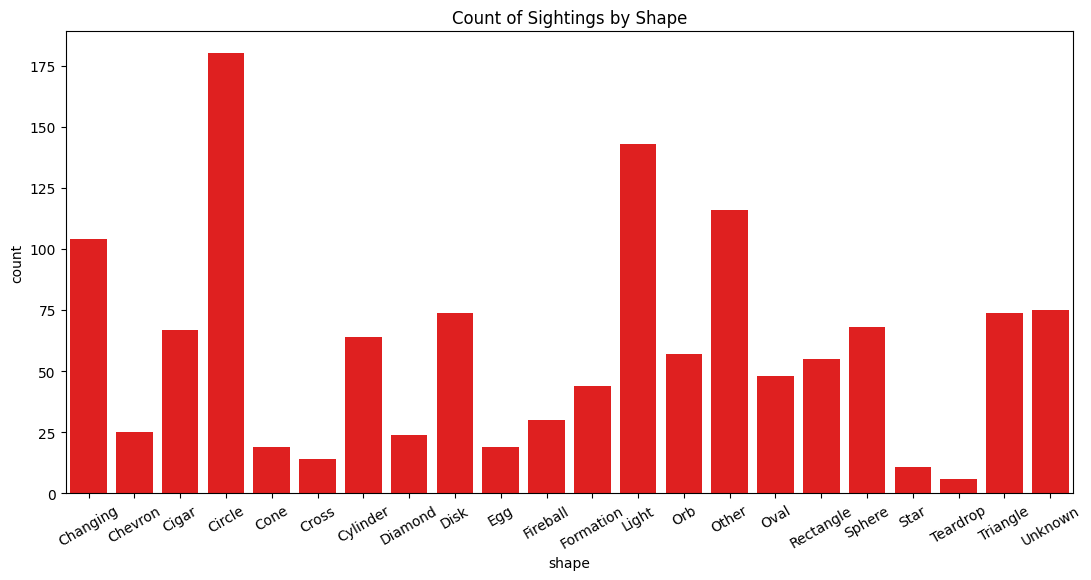

In [ ]:
plt.figure(figsize=(13,6))
ax = sns.barplot(data=shapes, x="shape", y="count", color='red')
ax.set_xticklabels(shapes['shape'], rotation=30)
plt.title('Count of Sightings by Shape')
plt.show()

In [ ]:
shapes_year = ufo_data.groupby(['shape','date_year']).count().reset_index()

Text(0.5, 1.0, 'Shape Sightings by Year')

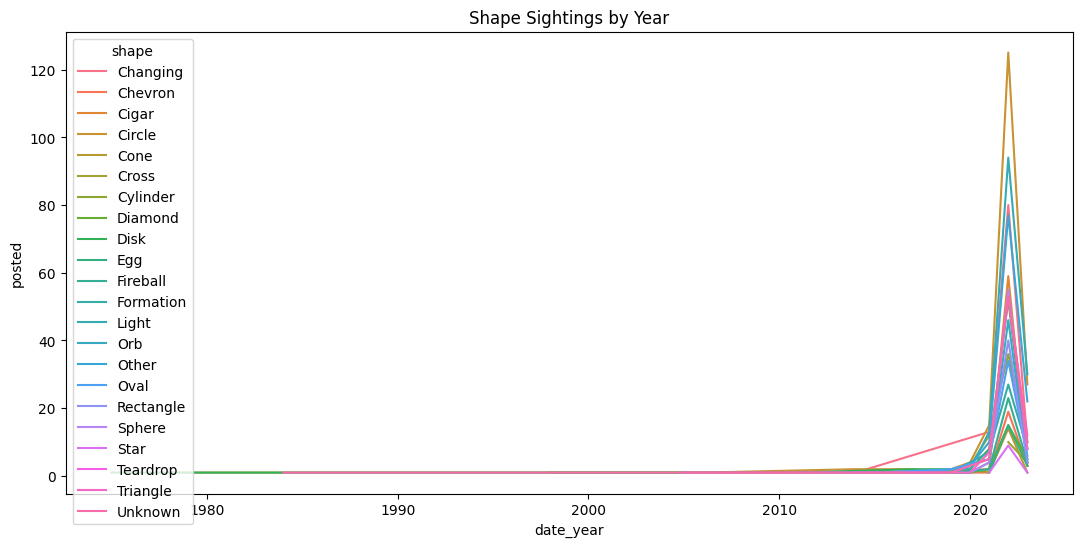

In [ ]:
plt.figure(figsize=(13,6))
sns.lineplot(data=shapes_year, x="date_year", y="posted", hue="shape")
plt.title('Shape Sightings by Year')

### Text Embedding Generation

For this example, we embed only the summary. A future iteration should consider handling the duration column.

In [ ]:
ufo_data.head()

,posted,date,time,city,state,shape,duration,summary,images,img_link,lat,lng,population,date_value,date_month,date_year,date_month_year
0,03/06/23,03/05/23,20:47:00,Villas,NJ,Diamond,Few minutes long,Low flying aircraft,Yes,https://nuforc.org/webreports/reports/174/S174...,39.0157,-74.9350,9866,2023-03-05,3,2023,03/2023
1,03/06/23,03/05/23,19:00:00,Mooresville,NC,Orb,10 seconds,Turquoise colored light traveling from south t...,Yes,https://nuforc.org/webreports/reports/174/S174...,35.5847,-80.8266,48431,2023-03-05,3,2023,03/2023
2,03/06/23,03/05/23,12:30:00,Los Angeles,CA,Changing,4 min,Dark object triangular changed shape,Yes,https://nuforc.org/webreports/reports/174/S174...,34.1141,-118.4068,12121244,2023-03-05,3,2023,03/2023
3,03/06/23,03/05/23,00:30:00,Brooklyn,NY,Light,Atleast 10 mins,"Light object sky, In Brooklyn towards Manhattan",Yes,https://nuforc.org/webreports/reports/174/S174...,40.6501,-73.9496,2736074,2023-03-05,3,2023,03/2023
4,03/06/23,03/04/23,23:49:00,Enid,OK,Formation,NaN,It suddenly appeared over rhe neighbors house ...,Yes,https://nuforc.org/webreports/reports/174/S174...,36.4063,-97.8700,51129,2023-03-04,3,2023,03/2023


In [ ]:
#Helper function from OpenAI docs to generate embeddings
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

In [ ]:
ufo_data['summary_embedding'] = ufo_data.summary.apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
#Optional - write out to csv
ufo_data.to_csv('/content/ufo_embeddings.csv', index=False)

In [ ]:
#Optional - Read back in the embeddings
#ufo_cluster_df = pd.read_csv('/content/ufo_embeddings.csv')
#ufo_cluster_df['summary_embedding'] = ufo_cluster_df.summary_embedding.apply(eval).apply(np.array)

#### View dataframe with added embeddings

We now have a dataset which contains text embeddings for clustering. From here, we can then start to build a scaled dataset for k-means clustering.

In [ ]:
ufo_data.head()

,posted,date,time,city,state,shape,duration,summary,images,img_link,lat,lng,population,date_value,date_month,date_year,date_month_year,summary_embedding
0,03/06/23,03/05/23,20:47:00,Villas,NJ,Diamond,Few minutes long,Low flying aircraft,Yes,https://nuforc.org/webreports/reports/174/S174...,39.0157,-74.9350,9866,2023-03-05,3,2023,03/2023,"[-0.009386943653225899, -0.006182525772601366,..."
1,03/06/23,03/05/23,19:00:00,Mooresville,NC,Orb,10 seconds,Turquoise colored light traveling from south t...,Yes,https://nuforc.org/webreports/reports/174/S174...,35.5847,-80.8266,48431,2023-03-05,3,2023,03/2023,"[-0.013449913822114468, -0.005647785030305386,..."
2,03/06/23,03/05/23,12:30:00,Los Angeles,CA,Changing,4 min,Dark object triangular changed shape,Yes,https://nuforc.org/webreports/reports/174/S174...,34.1141,-118.4068,12121244,2023-03-05,3,2023,03/2023,"[0.0021505362819880247, -0.00734280701726675, ..."
3,03/06/23,03/05/23,00:30:00,Brooklyn,NY,Light,Atleast 10 mins,"Light object sky, In Brooklyn towards Manhattan",Yes,https://nuforc.org/webreports/reports/174/S174...,40.6501,-73.9496,2736074,2023-03-05,3,2023,03/2023,"[0.0038657470140606165, -0.010969470255076885,..."
4,03/06/23,03/04/23,23:49:00,Enid,OK,Formation,NaN,It suddenly appeared over rhe neighbors house ...,Yes,https://nuforc.org/webreports/reports/174/S174...,36.4063,-97.8700,51129,2023-03-04,3,2023,03/2023,"[-0.020363906398415565, 0.0013887370005249977,..."


### Scaling Features

We have some features we want to scale, namely population.

In [ ]:
scaler = StandardScaler()
ufo_data['population_scaled'] = scaler.fit_transform(ufo_data['population'].values.reshape(-1, 1))

In [ ]:
ufo_data.head()

,posted,date,time,city,state,shape,duration,summary,images,img_link,lat,lng,population,date_value,date_month,date_year,date_month_year,summary_embedding,population_scaled
0,03/06/23,03/05/23,20:47:00,Villas,NJ,Diamond,Few minutes long,Low flying aircraft,Yes,https://nuforc.org/webreports/reports/174/S174...,39.0157,-74.9350,9866,2023-03-05,3,2023,03/2023,"[-0.009386943653225899, -0.006182525772601366,...",-0.321358
1,03/06/23,03/05/23,19:00:00,Mooresville,NC,Orb,10 seconds,Turquoise colored light traveling from south t...,Yes,https://nuforc.org/webreports/reports/174/S174...,35.5847,-80.8266,48431,2023-03-05,3,2023,03/2023,"[-0.013449913822114468, -0.005647785030305386,...",-0.298786
2,03/06/23,03/05/23,12:30:00,Los Angeles,CA,Changing,4 min,Dark object triangular changed shape,Yes,https://nuforc.org/webreports/reports/174/S174...,34.1141,-118.4068,12121244,2023-03-05,3,2023,03/2023,"[0.0021505362819880247, -0.00734280701726675, ...",6.767297
3,03/06/23,03/05/23,00:30:00,Brooklyn,NY,Light,Atleast 10 mins,"Light object sky, In Brooklyn towards Manhattan",Yes,https://nuforc.org/webreports/reports/174/S174...,40.6501,-73.9496,2736074,2023-03-05,3,2023,03/2023,"[0.0038657470140606165, -0.010969470255076885,...",1.274261
4,03/06/23,03/04/23,23:49:00,Enid,OK,Formation,NaN,It suddenly appeared over rhe neighbors house ...,Yes,https://nuforc.org/webreports/reports/174/S174...,36.4063,-97.8700,51129,2023-03-04,3,2023,03/2023,"[-0.020363906398415565, 0.0013887370005249977,...",-0.297207


### Duration

*To do!* We want to be able to start to use this duration data, but it requires quite a lot of clean-up.

In [ ]:
ufo_data['duration'].value_counts()
ufo_data['duration'] = ufo_data['duration'].fillna('')

In [ ]:
ufo_data[ufo_data['duration'].str.contains("min")].head(3)

,posted,date,time,city,state,shape,duration,summary,images,img_link,lat,lng,population,date_value,date_month,date_year,date_month_year,summary_embedding,population_scaled
0,03/06/23,03/05/23,20:47:00,Villas,NJ,Diamond,Few minutes long,Low flying aircraft,Yes,https://nuforc.org/webreports/reports/174/S174...,39.0157,-74.9350,9866,2023-03-05,3,2023,03/2023,"[-0.009386943653225899, -0.006182525772601366,...",-0.321358
2,03/06/23,03/05/23,12:30:00,Los Angeles,CA,Changing,4 min,Dark object triangular changed shape,Yes,https://nuforc.org/webreports/reports/174/S174...,34.1141,-118.4068,12121244,2023-03-05,3,2023,03/2023,"[0.0021505362819880247, -0.00734280701726675, ...",6.767297
3,03/06/23,03/05/23,00:30:00,Brooklyn,NY,Light,Atleast 10 mins,"Light object sky, In Brooklyn towards Manhattan",Yes,https://nuforc.org/webreports/reports/174/S174...,40.6501,-73.9496,2736074,2023-03-05,3,2023,03/2023,"[0.0038657470140606165, -0.010969470255076885,...",1.274261


### One-Hot Encoding
Future iterations need to be able to cope with the lat/long data, which does raise the question of if K-means is an appropriate algorithm for this exercise. However, for now we'll leverage the state level information to input geographic features into the model.

Alongside this, we'll also one hot encode shape as a field. As our dataset is going to get very wide, we'll take only the columns we need for now and put into a new subsetted dataframe from here on.

In [81]:
ufo_data_subset = ufo_data[['state', 'city', 'date_month', 'date_year','summary_embedding','population_scaled','shape','state']]

In [82]:
# Perform one-hot encoding on the 'state' column
shape_encoded = pd.get_dummies(ufo_data_subset['shape'], prefix='shape_')
state_encoded = pd.get_dummies(ufo_data_subset['state'], prefix='state_')
state_encoded = pd.get_dummies(ufo_data_subset['city'], prefix='city_')

# Concatenate the one-hot encoded columns with the original dataframe
ufo_data_encoded = pd.concat([ufo_data_subset, shape_encoded, state_encoded], axis=1)

# Drop the original 'shape' and 'state' columns if you don't need them anymore
ufo_data_encoded = ufo_data_encoded.drop(['shape', 'state','city'], axis=1)

In [83]:
ufo_data_encoded.head()

,date_month,date_year,summary_embedding,population_scaled,shape__Changing,shape__Chevron,shape__Cigar,shape__Circle,shape__Cone,shape__Cross,...,city__las vegas,city__lexington,city__medford,city__menasha,city__mooreland,city__palm bay,city__philadelphia,city__pikesville,city__tyrone,city__westlake village
0,3,2023,"[-0.009386943653225899, -0.006182525772601366,...",-0.321358,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,2023,"[-0.013449913822114468, -0.005647785030305386,...",-0.298786,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2023,"[0.0021505362819880247, -0.00734280701726675, ...",6.767297,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2023,"[0.0038657470140606165, -0.010969470255076885,...",1.274261,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,2023,"[-0.020363906398415565, 0.0013887370005249977,...",-0.297207,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Optional - storing a sample
#ufo_data_encoded.head().to_csv('/content/code_input.csv')

#### Wrangling embeddings

We then change the format of the embeddings using vstack, and join back onto the dataframe.

In [84]:
matrix = np.vstack(ufo_data_encoded.summary_embedding.values)

In [85]:
other_columns = ufo_data_encoded.drop(columns=['summary_embedding']).values

In [86]:
# Concatenate the embeddings with the other columns
ufo_model_input = np.hstack((matrix, other_columns))

# Check the shape of the concatenated data
ufo_model_input.shape

(1317, 2512)

### Clustering

With our dataset complete (barring the to-dos!) we then cluster the data using K-Means Clustering.

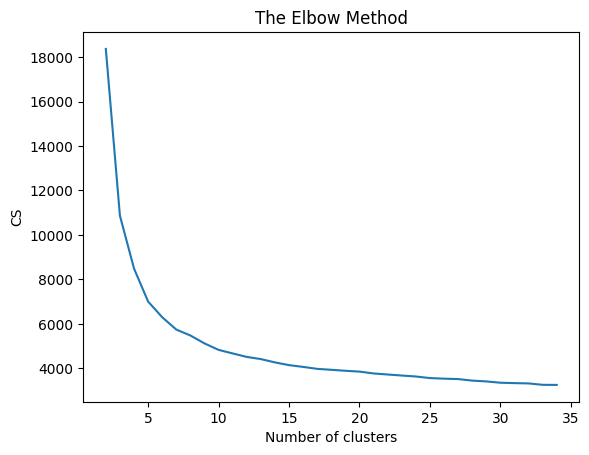

In [88]:
#Source https://www.kaggle.com/code/prashant111/k-means-clustering-with-python
from sklearn.metrics import silhouette_score
cs = []
silo = []
for i in range(2, 35):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(ufo_model_input)
    cs.append(kmeans.inertia_)
    silo.append(silhouette_score(ufo_model_input, kmeans.labels_))
plt.plot(range(2, 35), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [89]:
##View silo scores
print(silo)

[0.4570236126261955, 0.4687783645045106, 0.3525940314884711, 0.3599585552574368, 0.2751401051971007, 0.2801750493781544, 0.22656820065988864, 0.22865102847124885, 0.23435912283273022, 0.1544417560701783, 0.1697632305746348, 0.13787000655460868, 0.13631654128837745, 0.14275803181217733, 0.14362109285247646, 0.1400332763749216, 0.11167313703427409, 0.101084505117194, 0.0882640467967983, 0.09709606548725712, 0.09484144467846192, 0.11684658734154277, 0.08609272645605087, 0.09828801755950171, 0.09415531057681366, 0.09458434246542509, 0.09507125487906411, 0.09450279049399564, 0.0894333997886017, 0.09151772774358008, 0.09326484755431276, 0.09282995295014125, 0.09341225461467446]


### Fitting with a good amount of clusters

The highest silhouette score falls at 3 clusters, however - trialling in this iteration with 5 clusters.



In [90]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(ufo_model_input)

KMeans(n_clusters=5, n_init=10, random_state=0)

Applying the cluster labels back onto the original dataset (need to validate)

In [91]:
cluster_labels = kmeans.labels_
ufo_data_output = ufo_data #Creating a new var
ufo_data_output['cluster'] = cluster_labels

### Cluster Overview

In [92]:
ufo_data_output.groupby(['cluster']).count()

,posted,date,time,city,state,shape,duration,summary,images,img_link,lat,lng,population,date_value,date_month,date_year,date_month_year,summary_embedding,population_scaled
cluster,,,,,,,,,,,,,,,,,,,
0,442,442,442,442,442,442,442,442,442,442,442,442,442,442,442,442,442,442,442
1,455,455,455,455,455,455,455,455,455,455,455,455,455,455,455,455,455,455,455
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
3,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396
4,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20


In [93]:
ufo_data_output.groupby(['cluster']).count()

,posted,date,time,city,state,shape,duration,summary,images,img_link,lat,lng,population,date_value,date_month,date_year,date_month_year,summary_embedding,population_scaled
cluster,,,,,,,,,,,,,,,,,,,
0,442,442,442,442,442,442,442,442,442,442,442,442,442,442,442,442,442,442,442
1,455,455,455,455,455,455,455,455,455,455,455,455,455,455,455,455,455,455,455
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
3,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396
4,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20


In [94]:
ufo_data_output[ufo_data_output['cluster'] == 0]

,posted,date,time,city,state,shape,duration,summary,images,img_link,lat,lng,population,date_value,date_month,date_year,date_month_year,summary_embedding,population_scaled,cluster
178,03/06/23,12/31/22,22:55:00,Liberty Hill,TX,Circle,Approximately two seconds,"Late evening, New Years eve 2022, observed sma...",Yes,https://nuforc.org/webreports/reports/174/S174...,30.6638,-97.9063,4017,2022-12-31,12,2022,12/2022,"[-0.0002560344582889229, -0.003215969074517488...",-0.324781,0
179,03/06/23,12/31/22,19:40:00,Cass Lake,MN,Orb,3 minutes,Glowing orange circles pulsating silently east...,Yes,https://nuforc.org/webreports/reports/173/S173...,47.3792,-94.5993,558,2022-12-31,12,2022,12/2022,"[-0.0020012089516967535, 0.0020943658892065287...",-0.326806,0
180,03/06/23,12/30/22,18:56:00,Iowa City,IA,Unknown,1 minute,Hovering Lights above I-80 in Coralville,Yes,https://nuforc.org/webreports/reports/173/S173...,41.6559,-91.5303,120015,2022-12-30,12,2022,12/2022,"[0.0034551562275737524, -0.008256563916802406,...",-0.256889,0
181,03/06/23,12/29/22,17:10:00,Sarasota,FL,Disk,picture,Captured in background of photo,Yes,https://nuforc.org/webreports/reports/173/S173...,27.3387,-82.5432,727388,2022-12-29,12,2022,12/2022,"[-0.020257776603102684, 0.004164670128375292, ...",0.098600,0
182,03/06/23,12/28/22,19:02:00,Shiloh,PA,Cross,5 to 10 minutes,"Bright light in sky, wasn't still at 1st, even...",Yes,https://nuforc.org/webreports/reports/173/S173...,39.9732,-76.7920,11098,2022-12-28,12,2022,12/2022,"[-0.009754739701747894, -0.006190013140439987,...",-0.320637,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,12/19/21,12/19/21,00:15:00,Deltona,FL,Changing,"1 minute, 9 seconds video",I was on Ring app in house and saw incredible ...,Yes,https://nuforc.org/webreports/reports/165/S165...,28.9050,-81.2137,212616,2021-12-19,12,2021,12/2021,"[-0.015837429091334343, -0.002493055770173669,...",-0.202691,0
1311,12/19/21,12/17/21,22:30:00,Butte,MT,Orb,15 minutes,Saw orb that moved around the moon and got pic...,Yes,https://nuforc.org/webreports/reports/165/S165...,45.9020,-112.6571,34368,2021-12-17,12,2021,12/2021,"[0.0020993901416659355, -0.014487293548882008,...",-0.307017,0
1312,12/19/21,12/09/21,04:00:00,Staunton,VA,Circle,>20 minutes,The object was distinctively different than th...,Yes,https://nuforc.org/webreports/reports/165/S165...,38.1593,-79.0611,25358,2021-12-09,12,2021,12/2021,"[0.010060714557766914, 0.02052178978919983, -0...",-0.312291,0
1313,12/19/21,12/03/21,18:00:00,Wentworth,MO,Cylinder,,Long cylinderical craft with about 15 or 20 wh...,Yes,https://nuforc.org/webreports/reports/165/S165...,36.9932,-94.0756,85,2021-12-03,12,2021,12/2021,"[0.004976687952876091, -0.00013926524843554944...",-0.327083,0


In [95]:
ufo_data_output[ufo_data_output['cluster'] == 1]

,posted,date,time,city,state,shape,duration,summary,images,img_link,lat,lng,population,date_value,date_month,date_year,date_month_year,summary_embedding,population_scaled,cluster
0,03/06/23,03/05/23,20:47:00,Villas,NJ,Diamond,Few minutes long,Low flying aircraft,Yes,https://nuforc.org/webreports/reports/174/S174...,39.0157,-74.9350,9866,2023-03-05,3,2023,03/2023,"[-0.009386943653225899, -0.006182525772601366,...",-0.321358,1
1,03/06/23,03/05/23,19:00:00,Mooresville,NC,Orb,10 seconds,Turquoise colored light traveling from south t...,Yes,https://nuforc.org/webreports/reports/174/S174...,35.5847,-80.8266,48431,2023-03-05,3,2023,03/2023,"[-0.013449913822114468, -0.005647785030305386,...",-0.298786,1
2,03/06/23,03/05/23,12:30:00,Los Angeles,CA,Changing,4 min,Dark object triangular changed shape,Yes,https://nuforc.org/webreports/reports/174/S174...,34.1141,-118.4068,12121244,2023-03-05,3,2023,03/2023,"[0.0021505362819880247, -0.00734280701726675, ...",6.767297,1
3,03/06/23,03/05/23,00:30:00,Brooklyn,NY,Light,Atleast 10 mins,"Light object sky, In Brooklyn towards Manhattan",Yes,https://nuforc.org/webreports/reports/174/S174...,40.6501,-73.9496,2736074,2023-03-05,3,2023,03/2023,"[0.0038657470140606165, -0.010969470255076885,...",1.274261,1
4,03/06/23,03/04/23,23:49:00,Enid,OK,Formation,,It suddenly appeared over rhe neighbors house ...,Yes,https://nuforc.org/webreports/reports/174/S174...,36.4063,-97.8700,51129,2023-03-04,3,2023,03/2023,"[-0.020363906398415565, 0.0013887370005249977,...",-0.297207,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,03/04/22,01/01/22,00:07:00,Tualatin,OR,Other,6ish minutes for all them,"After New Years Eve firework display, I saw up...",Yes,https://nuforc.org/webreports/reports/166/S166...,45.3772,-122.7748,27821,2022-01-01,1,2022,01/2022,"[-0.004840813111513853, -0.01193206012248993, ...",-0.310849,1
1297,03/04/22,02/23/21,04:21:00,Arlington,VA,Orb,>10 minutes,"Bright orange orb hovered adjacent to, near to...",Yes,https://nuforc.org/webreports/reports/166/S166...,38.8786,-77.1011,235764,2021-02-23,2,2021,02/2021,"[0.007076587527990341, -0.02804303541779518, -...",-0.189142,1
1298,03/04/22,01/17/21,13:31:00,MESA,AZ,Cylinder,UFO next to aircraft pic,Testing long range focus of 300 mm Nikon lens ...,Yes,https://nuforc.org/webreports/reports/166/S166...,33.4015,-111.7178,497752,2021-01-17,1,2021,01/2021,"[-0.0004308594507165253, -0.007034713868051767...",-0.035804,1
1299,03/04/22,01/01/21,00:02:00,San Diego,CA,Formation,17 minutes,"Moving Orange Circle Formation, Seen over Mult...",Yes,https://nuforc.org/webreports/reports/166/S166...,32.8313,-117.1222,3084174,2021-01-01,1,2021,01/2021,"[-0.013796180486679077, -0.025309979915618896,...",1.478000,1


In [96]:
ufo_data_output[ufo_data_output['cluster'] == 2]

,posted,date,time,city,state,shape,duration,summary,images,img_link,lat,lng,population,date_value,date_month,date_year,date_month_year,summary_embedding,population_scaled,cluster
272,03/06/23,01/03/80,16:50:00,Los Angeles,CA,Disk,Approximately 10 minutes,A huge brightly-lit aerial object approached a...,Yes,https://nuforc.org/webreports/reports/174/S174...,34.1141,-118.4068,12121244,1980-01-03,1,1980,01/1980,"[0.007767151575535536, -0.0014305324293673038,...",6.767297,2
497,12/22/22,11/08/84,20:00:00,Brewster,NY,Unknown,10 minutes,Massive black ship moving slowly about 3X tr...,Yes,https://nuforc.org/webreports/reports/173/S173...,41.3970,-73.6151,2505,1984-11-08,11,1984,11/1984,"[-0.006869147531688213, -0.027423184365034103,...",-0.325666,2
854,09/09/22,09/01/75,21:30:00,Dallas,TX,Disk,5 minutes,"A large disk craft hovered over 635, then inst...",Yes,https://nuforc.org/webreports/reports/170/S170...,32.7935,-96.7667,5668165,1975-09-01,9,1975,09/1975,"[0.007319093216210604, 0.0045190840028226376, ...",2.990381,2
1309,03/04/22,12/18/78,18:00:00,Albuquerque,NM,Circle,Approx. 30 sec to 1 min,"Flat, Round, Fully Illuminated UFO over Neighb...",Yes,https://nuforc.org/webreports/reports/166/S166...,35.1054,-106.6465,765693,1978-12-18,12,1978,12/1978,"[-0.006854245439171791, 0.006580719258636236, ...",0.121019,2


In [97]:
shapes_counts = ufo_data_output.groupby(['shape','cluster']).count().reset_index()

In [98]:
#ufo_cluster_df.to_csv('/content/outputforchatgpt.csv')

#### Shape Distribution by Cluster

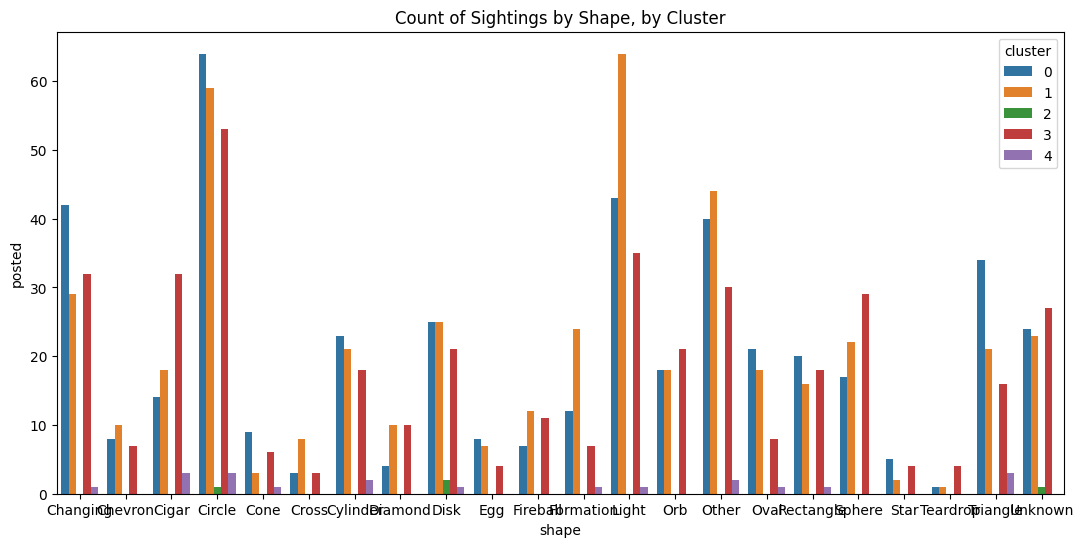

In [99]:
plt.figure(figsize=(13,6))
ax = sns.barplot(data=shapes_counts, x="shape", y="posted", hue='cluster')
plt.title('Count of Sightings by Shape, by Cluster')
plt.show()

#### State Distribution by Cluster

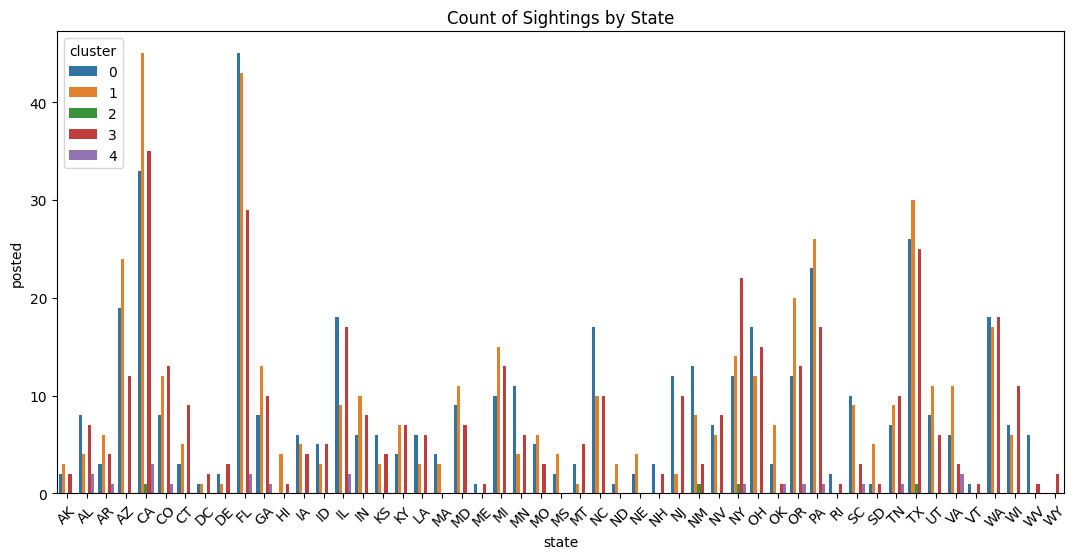

In [100]:
states_counts = ufo_data_output.groupby(['state','cluster']).count().reset_index()
plt.figure(figsize=(13,6))
ax = sns.barplot(data=states_counts, x="state", y="posted", hue='cluster')
ax.set_xticklabels(count_state['state'], rotation=45)
plt.title('Count of Sightings by State')
plt.show()

#### Cluster Distributions by Time

We can see that the split in clusters is truly by time. We should re-run a version of the model without calendar values to see what happens - or try encoding the data cyclically too.

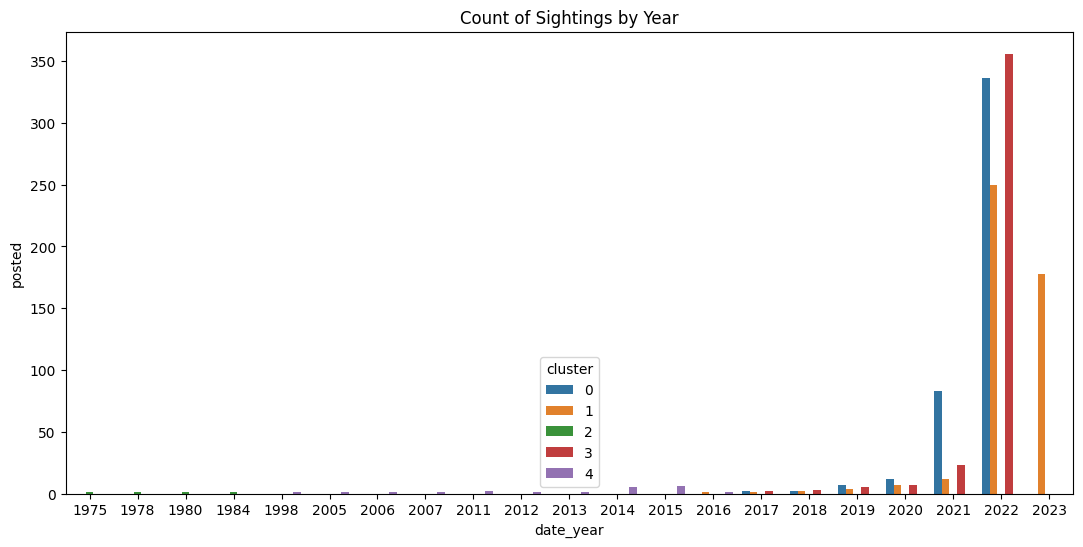

In [101]:
calendar_vals = ufo_data_output.groupby(['date_year','cluster']).count().reset_index()
plt.figure(figsize=(13,6))
ax = sns.barplot(data=calendar_vals, x="date_year", y="posted", hue='cluster')
plt.title('Count of Sightings by Year')
plt.show()

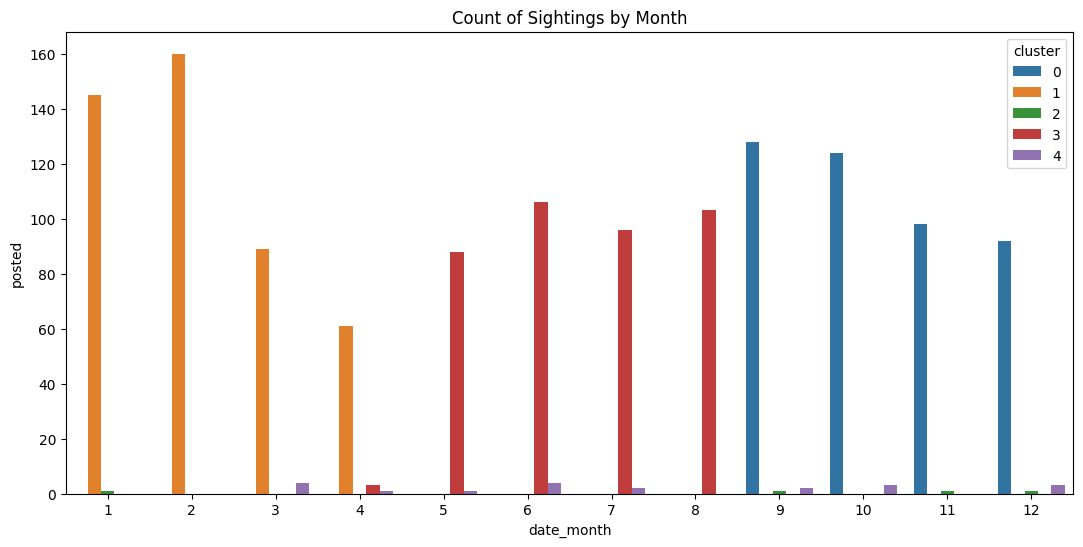

In [102]:
month_vals = ufo_data_output.groupby(['date_month','cluster']).count().reset_index()
plt.figure(figsize=(13,6))
ax = sns.barplot(data=month_vals, x="date_month", y="posted", hue='cluster')
plt.title('Count of Sightings by Month')
plt.show()

### Re-Run without calendar features

In [103]:
ufo_data_encoded.head()

,date_month,date_year,summary_embedding,population_scaled,shape__Changing,shape__Chevron,shape__Cigar,shape__Circle,shape__Cone,shape__Cross,...,city__las vegas,city__lexington,city__medford,city__menasha,city__mooreland,city__palm bay,city__philadelphia,city__pikesville,city__tyrone,city__westlake village
0,3,2023,"[-0.009386943653225899, -0.006182525772601366,...",-0.321358,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,2023,"[-0.013449913822114468, -0.005647785030305386,...",-0.298786,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2023,"[0.0021505362819880247, -0.00734280701726675, ...",6.767297,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2023,"[0.0038657470140606165, -0.010969470255076885,...",1.274261,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,2023,"[-0.020363906398415565, 0.0013887370005249977,...",-0.297207,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
ufo_data_encoded.columns

Index(['date_month', 'date_year', 'summary_embedding', 'population_scaled',
       'shape__Changing', 'shape__Chevron', 'shape__Cigar', 'shape__Circle',
       'shape__Cone', 'shape__Cross',
       ...
       'city__las vegas', 'city__lexington', 'city__medford', 'city__menasha',
       'city__mooreland', 'city__palm bay', 'city__philadelphia',
       'city__pikesville', 'city__tyrone', 'city__westlake village'],
      dtype='object', length=977)

In [105]:
other_columns_no_cal = ufo_data_encoded.drop(columns=['summary_embedding','date_month','date_year']).values

In [106]:
# Concatenate the embeddings with the other columns
ufo_model_input_no_cal = np.hstack((matrix, other_columns_no_cal))

# Check the shape of the concatenated data
ufo_model_input_no_cal.shape

(1317, 2510)

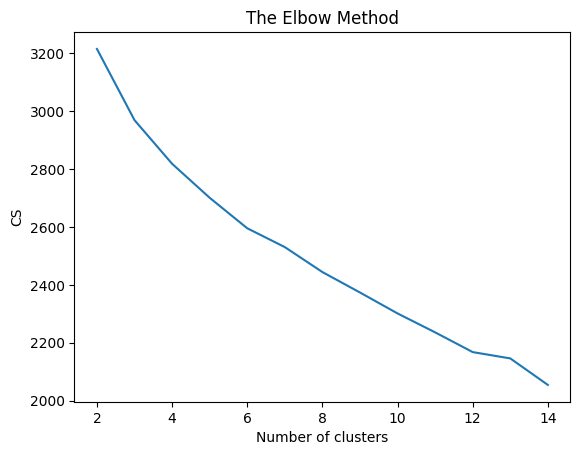

In [118]:
#Source https://www.kaggle.com/code/prashant111/k-means-clustering-with-python
cs = []
silo = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(ufo_model_input_no_cal)
    cs.append(kmeans.inertia_)
    silo.append(silhouette_score(ufo_model_input_no_cal, kmeans.labels_))
plt.plot(range(2, 15), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [119]:
silo

[0.5368488769740727,
 0.23636771219518582,
 0.06342875950166571,
 0.08350478825744365,
 0.10400316427640217,
 0.10270742435337163,
 0.12595576173388998,
 0.1395037328350632,
 0.15634386984762763,
 0.15311334426534878,
 0.18165189423820696,
 0.16820891246531192,
 0.1860840927427856]

### Encoding Months as Cyclic Features
In this example, we encode the months as cyclic features, and re-run our clusters.

In [109]:
months_in_year = 12

ufo_data_encoded['sin_month'] = np.sin(2*np.pi*ufo_data_encoded['date_month']/months_in_year)
ufo_data_encoded['cos_month'] = np.cos(2*np.pi*ufo_data_encoded['date_month']/months_in_year)

In [125]:
ufo_data_encoded.tail()

,date_month,date_year,summary_embedding,population_scaled,shape__Changing,shape__Chevron,shape__Cigar,shape__Circle,shape__Cone,shape__Cross,...,city__medford,city__menasha,city__mooreland,city__palm bay,city__philadelphia,city__pikesville,city__tyrone,city__westlake village,sin_month,cos_month
1312,12,2021,"[0.010060714557766914, 0.02052178978919983, -0...",-0.312291,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,-2.449294e-16,1.000000e+00
1313,12,2021,"[0.004976687952876091, -0.00013926524843554944...",-0.327083,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-2.449294e-16,1.000000e+00
1314,9,2021,"[-0.0073552620597183704, -0.007910619489848614...",-0.326505,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.000000e+00,-1.836970e-16
1315,2,2020,"[-0.03027980774641037, -0.009248418733477592, ...",-0.187433,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8.660254e-01,5.000000e-01
1316,3,2015,"[-0.011432759463787079, -0.019686784595251083,...",-0.317494,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1.000000e+00,6.123234e-17


In [131]:
other_columns_cyclic = ufo_data_encoded.drop(columns=['summary_embedding','date_month']).values
#Fix on future re-run to drop cos-year beforehand.

In [129]:
ufo_data_encoded.drop(columns=['summary_embedding','date_month'])

,date_year,population_scaled,shape__Changing,shape__Chevron,shape__Cigar,shape__Circle,shape__Cone,shape__Cross,shape__Cylinder,shape__Diamond,...,city__medford,city__menasha,city__mooreland,city__palm bay,city__philadelphia,city__pikesville,city__tyrone,city__westlake village,sin_month,cos_month
0,2023,-0.321358,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1.000000e+00,6.123234e-17
1,2023,-0.298786,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.000000e+00,6.123234e-17
2,2023,6.767297,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.000000e+00,6.123234e-17
3,2023,1.274261,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.000000e+00,6.123234e-17
4,2023,-0.297207,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.000000e+00,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,2021,-0.312291,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,-2.449294e-16,1.000000e+00
1313,2021,-0.327083,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,-2.449294e-16,1.000000e+00
1314,2021,-0.326505,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.000000e+00,-1.836970e-16
1315,2020,-0.187433,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8.660254e-01,5.000000e-01


In [130]:
# Concatenate the embeddings with the other columns
ufo_model_input_cyclic = np.hstack((matrix, other_columns_cyclic))

# Check the shape of the concatenated data
ufo_model_input_cyclic.shape

(1317, 2513)

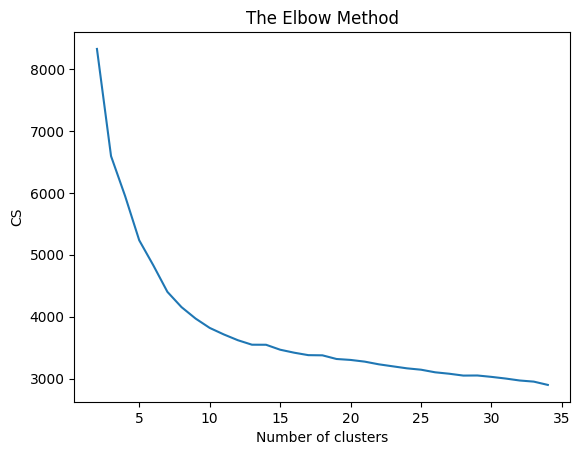

In [113]:
#Source https://www.kaggle.com/code/prashant111/k-means-clustering-with-python
from sklearn.metrics import davies_bouldin_score
cs = []
silo = []
db = []
for i in range(2, 35):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(ufo_model_input_cyclic)
    cs.append(kmeans.inertia_)
    silo.append(silhouette_score(ufo_model_input_cyclic, kmeans.labels_))
    db.append(davies_bouldin_score(ufo_model_input_cyclic, kmeans.labels_))
plt.plot(range(2, 35), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

In [114]:
silo

[0.9185043031316711,
 0.69180836525286,
 0.11956542862582853,
 0.12792997919641666,
 0.12887118314070578,
 0.13096809154411815,
 0.13107009097221428,
 0.1340729828555737,
 0.11066226556090197,
 0.09891428536593026,
 0.10099929216205947,
 0.10241877520997376,
 0.08274773758798912,
 0.07952837677705325,
 0.07270161748528389,
 0.07801594666736118,
 0.06173025632577784,
 0.07657624300827107,
 0.07966776409348376,
 0.07094686844988612,
 0.05994523414842672,
 0.07452442649586258,
 0.07376389641297032,
 0.06615928546586522,
 0.07085255522455827,
 0.0699581494900536,
 0.06998435424928111,
 0.06444509837744954,
 0.08560591720571296,
 0.08415296624213137,
 0.0762274621353981,
 0.07282055451958204,
 0.08145191228731354]

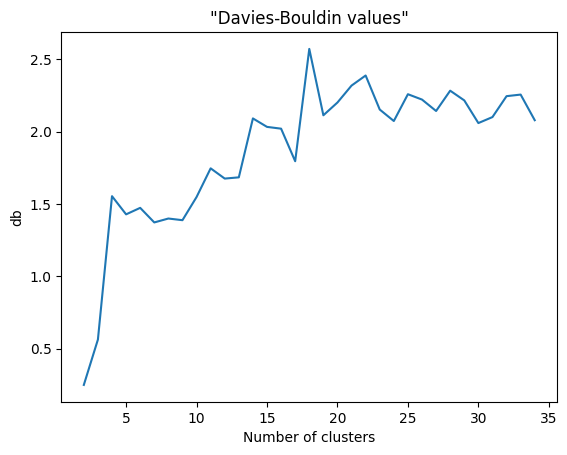

In [115]:
plt.plot(range(2, 35), db)
plt.title('"Davies-Bouldin values"')
plt.xlabel('Number of clusters')
plt.ylabel('db')
plt.show()

#### Fit with optimal amount of clusters

In [120]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(ufo_model_input_cyclic)

KMeans(n_clusters=3, n_init=10, random_state=0)

#### Join onto original dataset

In [121]:
cluster_labels = kmeans.labels_
ufo_data_output_cyclical = ufo_data #Creating a new var
ufo_data_output_cyclical['cluster'] = cluster_labels

In [122]:
ufo_data_output_cyclical.head()

,posted,date,time,city,state,shape,duration,summary,images,img_link,lat,lng,population,date_value,date_month,date_year,date_month_year,summary_embedding,population_scaled,cluster
0,03/06/23,03/05/23,20:47:00,Villas,NJ,Diamond,Few minutes long,Low flying aircraft,Yes,https://nuforc.org/webreports/reports/174/S174...,39.0157,-74.9350,9866,2023-03-05,3,2023,03/2023,"[-0.009386943653225899, -0.006182525772601366,...",-0.321358,0
1,03/06/23,03/05/23,19:00:00,Mooresville,NC,Orb,10 seconds,Turquoise colored light traveling from south t...,Yes,https://nuforc.org/webreports/reports/174/S174...,35.5847,-80.8266,48431,2023-03-05,3,2023,03/2023,"[-0.013449913822114468, -0.005647785030305386,...",-0.298786,0
2,03/06/23,03/05/23,12:30:00,Los Angeles,CA,Changing,4 min,Dark object triangular changed shape,Yes,https://nuforc.org/webreports/reports/174/S174...,34.1141,-118.4068,12121244,2023-03-05,3,2023,03/2023,"[0.0021505362819880247, -0.00734280701726675, ...",6.767297,0
3,03/06/23,03/05/23,00:30:00,Brooklyn,NY,Light,Atleast 10 mins,"Light object sky, In Brooklyn towards Manhattan",Yes,https://nuforc.org/webreports/reports/174/S174...,40.6501,-73.9496,2736074,2023-03-05,3,2023,03/2023,"[0.0038657470140606165, -0.010969470255076885,...",1.274261,0
4,03/06/23,03/04/23,23:49:00,Enid,OK,Formation,,It suddenly appeared over rhe neighbors house ...,Yes,https://nuforc.org/webreports/reports/174/S174...,36.4063,-97.8700,51129,2023-03-04,3,2023,03/2023,"[-0.020363906398415565, 0.0013887370005249977,...",-0.297207,0


In [123]:
ufo_data_encoded.head()

,date_month,date_year,summary_embedding,population_scaled,shape__Changing,shape__Chevron,shape__Cigar,shape__Circle,shape__Cone,shape__Cross,...,city__medford,city__menasha,city__mooreland,city__palm bay,city__philadelphia,city__pikesville,city__tyrone,city__westlake village,sin_month,cos_month
0,3,2023,"[-0.009386943653225899, -0.006182525772601366,...",-0.321358,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,6.123234e-17
1,3,2023,"[-0.013449913822114468, -0.005647785030305386,...",-0.298786,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,6.123234e-17
2,3,2023,"[0.0021505362819880247, -0.00734280701726675, ...",6.767297,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,6.123234e-17
3,3,2023,"[0.0038657470140606165, -0.010969470255076885,...",1.274261,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,6.123234e-17
4,3,2023,"[-0.020363906398415565, 0.0013887370005249977,...",-0.297207,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,6.123234e-17


In [124]:
ufo_data_output_cyclical.groupby(['cluster']).count()

,posted,date,time,city,state,shape,duration,summary,images,img_link,lat,lng,population,date_value,date_month,date_year,date_month_year,summary_embedding,population_scaled
cluster,,,,,,,,,,,,,,,,,,,
0,1287,1287,1287,1287,1287,1287,1287,1287,1287,1287,1287,1287,1287,1287,1287,1287,1287,1287,1287
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26
